In [1]:
from ptycho.workflows.train_script_components import (
    parse_arguments,
    setup_configuration,
    load_and_prepare_data,
    run_cdi_example,
    save_outputs,
    logger,
    update_params
)

2024-08-16 16:27:48.550127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 16:27:48.550154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 16:27:48.551025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 16:27:48.555683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 16:27:49.129150: W tensorflow/compiler/tf2

1 items had no tests:
    __main__
0 tests in 1 items.
0 passed and 0 failed.
Test passed.


/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-08-16 16:27:50.402477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-16 16:27:50.402699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read fr

In [2]:
params = {
    "nepochs": 50,
    "output_prefix": "tmp",
    "intensity_scale.trainable": True,
    "positions.provided": True,
    "probe.big": True,
    "probe.mask": False,
    "data_source": "generic",
    "gridsize": 1,
    "probe_scale": 5,
    "train_data_file_path": None,
    "test_data_file_path": None,
    "N": 64
}

update_params(params)

In [3]:
import sys
sys.argv = [sys.argv[0], '--train_data_file_path', '../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz',
           '--test_data_file_path', '../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz']
args = parse_arguments()
config = setup_configuration(args, args.config)

2024-08-16 16:27:50,504 - INFO - Configuration setup complete
2024-08-16 16:27:50,504 - INFO - Final configuration: {'N': 64, 'offset': 4, 'gridsize': 1, 'outer_offset_train': None, 'outer_offset_test': None, 'batch_size': 16, 'nepochs': 50, 'n_filters_scale': 2, 'output_prefix': 'tmp', 'big_gridsize': 10, 'max_position_jitter': 10, 'sim_jitter_scale': 0.0, 'default_probe_scale': 0.7, 'mae_weight': 0.0, 'nll_weight': 1.0, 'tv_weight': 0.0, 'realspace_mae_weight': 0.0, 'realspace_weight': 0.0, 'nphotons': 1000000000.0, 'nimgs_train': 9, 'nimgs_test': 3, 'data_source': 'generic', 'probe.trainable': False, 'intensity_scale.trainable': True, 'positions.provided': True, 'object.big': True, 'probe.big': True, 'probe_scale': 5, 'set_phi': False, 'probe.mask': False, 'model_type': 'pinn', 'label': '', 'size': 392, 'amp_activation': 'sigmoid', 'h5_path': 'wts.h5', 'npseed': 42, 'debug': True, 'train_data_file_path': '../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz', 'test_data_file_path':

In [4]:
ptycho_data, ptycho_data_train, obj = load_and_prepare_data(config['train_data_file_path'])

diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)


In [5]:
import numpy as np
from ptycho.loader import RawData
import matplotlib.pyplot as plt
from ptycho.loader import RawData

def generate_simulated_data(objectGuess, probeGuess, nimages, buffer, random_seed=None):
    """
    Generate simulated ptychography data using random scan positions.

    Args:
        objectGuess (np.ndarray): Complex-valued 2D array representing the object.
        probeGuess (np.ndarray): Complex-valued 2D array representing the probe.
        nimages (int): Number of scan positions to generate.
        buffer (float): Border size to avoid when generating coordinates.
        random_seed (int, optional): Seed for random number generation. If None, uses system time.

    Returns:
        RawData: A RawData instance containing the simulated ptychography data.

    Raises:
        ValueError: If input parameters are invalid.
        RuntimeError: If an error occurs during simulation.
    """
    # Input validation
    if objectGuess.ndim != 2 or probeGuess.ndim != 2:
        raise ValueError("objectGuess and probeGuess must be 2D arrays")
    if not np.iscomplexobj(objectGuess) or not np.iscomplexobj(probeGuess):
        raise ValueError("objectGuess and probeGuess must be complex-valued")
    if nimages <= 0 or buffer < 0:
        raise ValueError("nimages must be positive and buffer must be non-negative")

    # Get object dimensions
    height, width = objectGuess.shape

    # Ensure buffer doesn't exceed image dimensions
    buffer = min(buffer, min(height, width) / 2 - 1)

    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random coordinates (floats)
    xcoords = np.random.uniform(buffer, width - buffer, nimages)
    ycoords = np.random.uniform(buffer, height - buffer, nimages)

    # Create scan_index
    scan_index = np.zeros(nimages, dtype=int)

    # Generate simulated data
    raw_data = RawData.from_simulation(xcoords, ycoords, probeGuess, objectGuess, scan_index)
    return raw_data


import numpy as np
from ptycho.loader import RawData

def load_probe_object(file_path):
    """
    Load object and probe guesses from a .npz file.

    Args:
        file_path (str): Path to the .npz file containing objectGuess and probeGuess.

    Returns:
        tuple: A tuple containing (objectGuess, probeGuess)

    Raises:
        ValueError: If required data is missing from the .npz file or if data is invalid.
        RuntimeError: If an error occurs during file loading.
    """
    try:
        with np.load(file_path) as data:
            if 'objectGuess' not in data or 'probeGuess' not in data:
                raise ValueError("The .npz file must contain 'objectGuess' and 'probeGuess'")
            
            objectGuess = data['objectGuess']
            probeGuess = data['probeGuess']

        # Validate extracted data
        if objectGuess.ndim != 2 or probeGuess.ndim != 2:
            raise ValueError("objectGuess and probeGuess must be 2D arrays")
        if not np.iscomplexobj(objectGuess) or not np.iscomplexobj(probeGuess):
            raise ValueError("objectGuess and probeGuess must be complex-valued")

        return objectGuess, probeGuess

    except Exception as e:
        raise RuntimeError(f"Error loading data from {file_path}: {str(e)}")

def simulate_from_npz(file_path, nimages, buffer=None, random_seed=None):
    """
    Load object and probe guesses from a .npz file and generate simulated ptychography data.

    Args:
        file_path (str): Path to the .npz file containing objectGuess and probeGuess.
        nimages (int): Number of scan positions to generate.
        buffer (float, optional): Border size to avoid when generating coordinates. 
                                  If None, defaults to 5% of the smaller dimension of objectGuess.
        random_seed (int, optional): Seed for random number generation. If None, uses system time.

    Returns:
        RawData: A RawData instance containing the simulated ptychography data.

    Raises:
        ValueError: If input parameters are invalid.
        RuntimeError: If an error occurs during simulation or file loading.
    """
    # Load guesses from file
    objectGuess, probeGuess = load_probe_object(file_path)

    # Set default buffer if not provided
    if buffer is None:
        buffer = min(objectGuess.shape) * 0.05  # 5% of the smaller dimension

    # Generate simulated data
    return generate_simulated_data(objectGuess, probeGuess, nimages, buffer, random_seed)



# Note: The generate_simulated_data function remains unchanged

# Example usage:
simulated_data = simulate_from_npz('../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz', nimages=100, buffer=10, random_seed=42)

# Example usage:
# simulated_data = generate_simulated_data(objectGuess, probeGuess, nimages=100, buffer=10, random_seed=42)

/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/tensorflow/python/ops/gen_math_ops.py:6751: ComplexWarning: Casting complex values to real discards the imaginary part
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


2024-08-16 16:27:51,670 - WARNING - From /home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/tensorflow_probability/python/distributions/distribution.py:342: calling _Independent.__init__ (from tensorflow_probability.python.distributions.independent) with reinterpreted_batch_ndims=None is deprecated and will be removed after 2022-03-01.
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


diff3d shape: (100, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (100,)
objectGuess shape: (227, 226)
xcoords shape: (100,)
ycoords shape: (100,)
xcoords_start shape: (100,)
ycoords_start shape: (100,)


input shape (None, 64, 64, 1)
diff3d shape: (100, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (100,)
objectGuess shape: (55, 100)
xcoords shape: (100,)
ycoords shape: (100,)
xcoords_start shape: (100,)
ycoords_start shape: (100,)


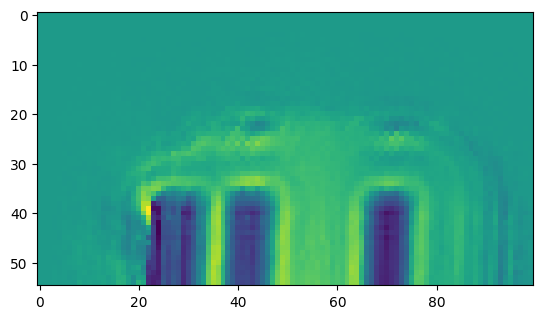

In [6]:
objectGuess, probeGuess = load_probe_object('../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz')
objectGuess = objectGuess[:55, :100]

plt.imshow(np.angle(objectGuess))

# Generate simulated data
tmp = generate_simulated_data(objectGuess, probeGuess, 100, 10, 0)

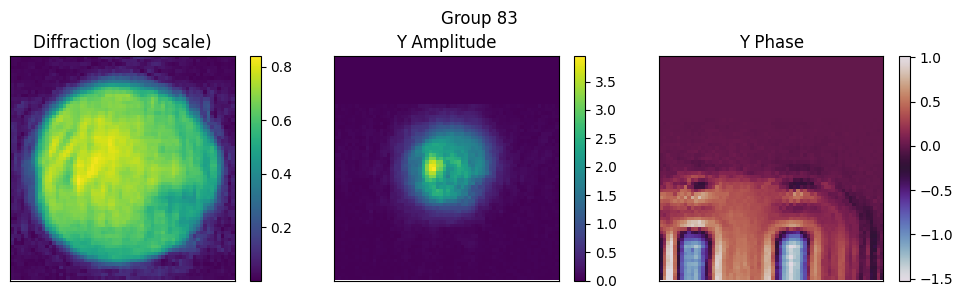

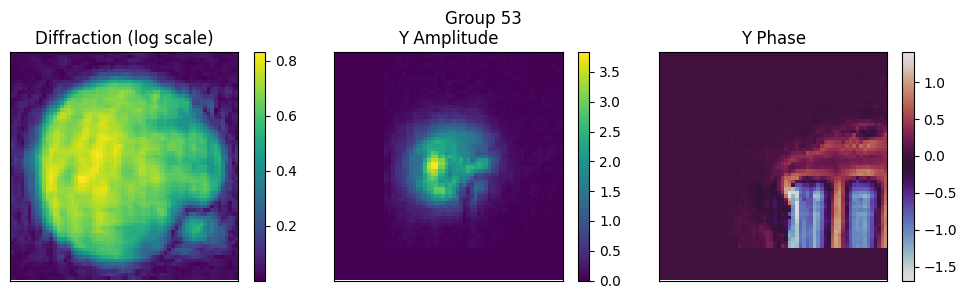

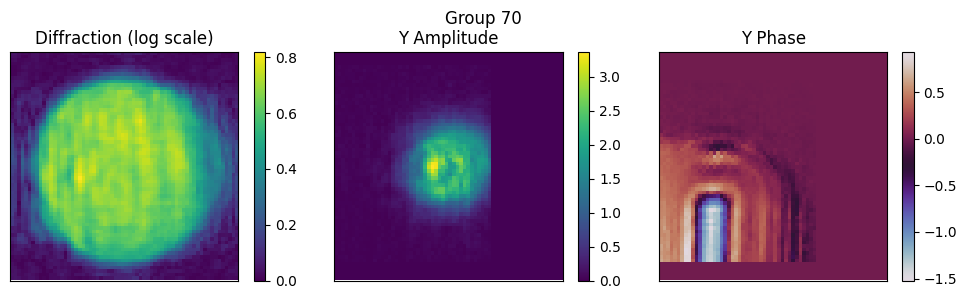

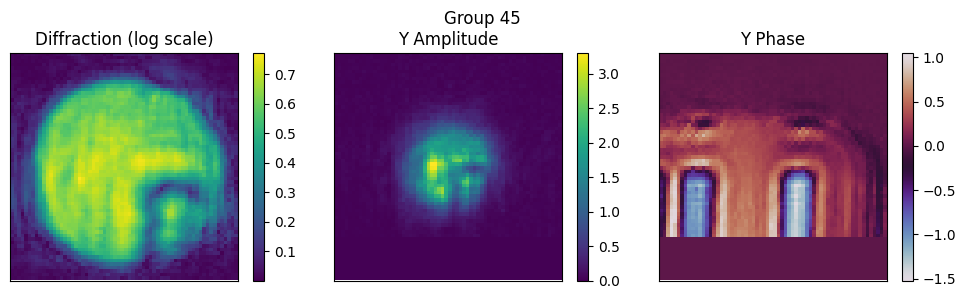

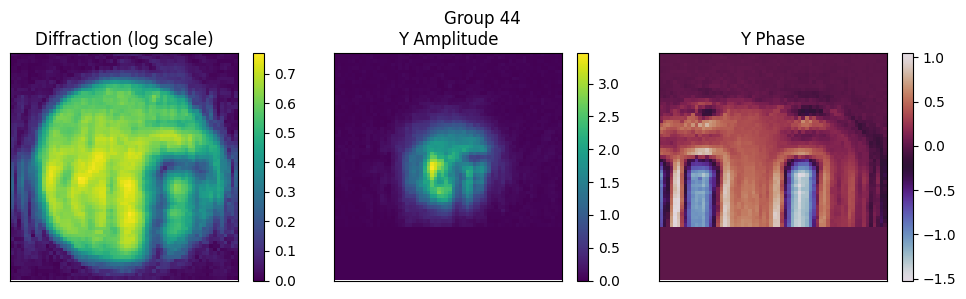

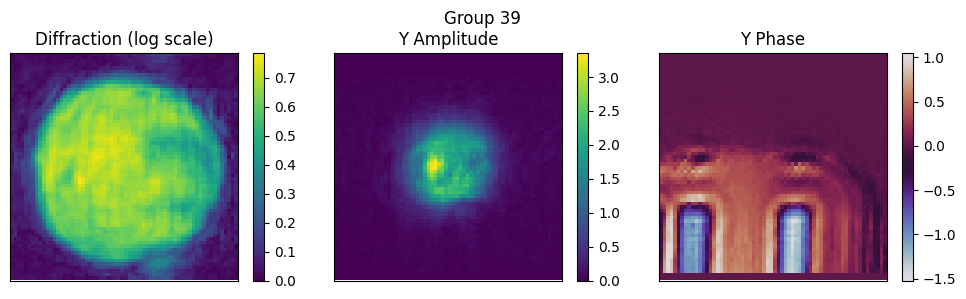

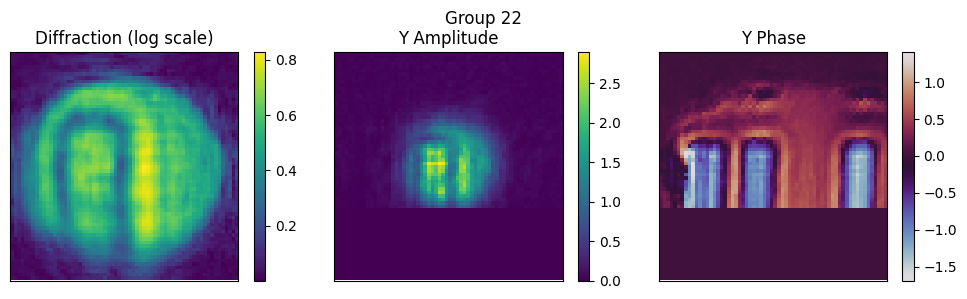

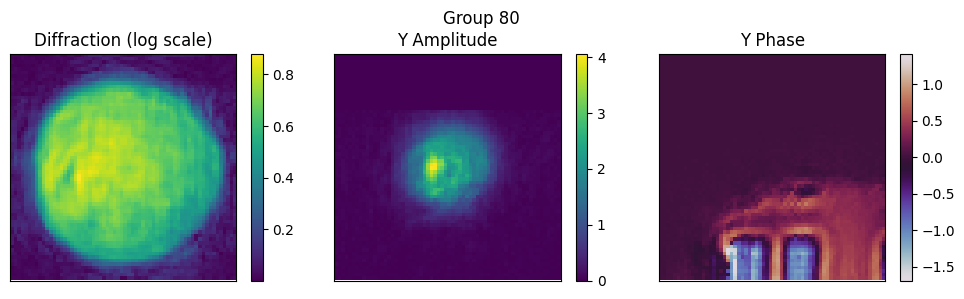

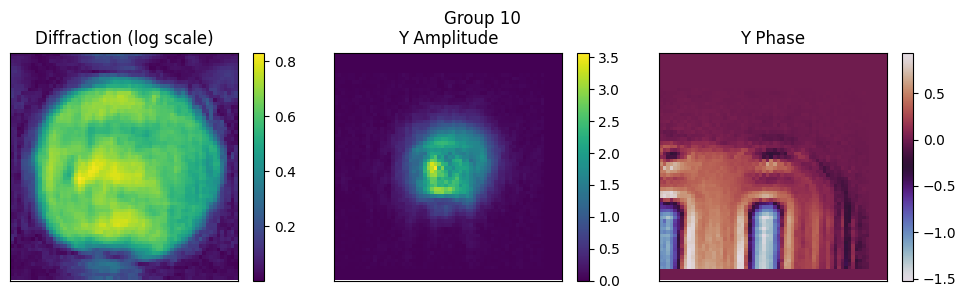

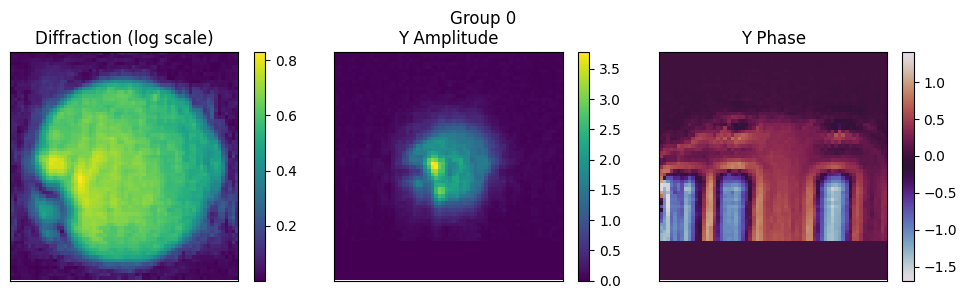

In [7]:


def plot_random_groups(tmp: RawData, K: int, figsize: tuple = (15, 5), seed: int = None):
    """
    Plot a random selection of K groups of (diffraction image, Y amplitude, Y phase) from a RawData object.

    Args:
        tmp (RawData): The RawData object containing the ptychography data.
        K (int): Number of groups to plot.
        figsize (tuple): Figure size for each group plot. Default is (15, 5).
        seed (int): Random seed for reproducibility. Default is None.

    Raises:
        ValueError: If K is greater than the number of available diffraction patterns.
    """
    if K > tmp.diff3d.shape[0]:
        raise ValueError(f"K ({K}) cannot be greater than the number of diffraction patterns ({tmp.diff3d.shape[0]})")

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Randomly select K indices
    indices = np.random.choice(tmp.diff3d.shape[0], K, replace=False)

    for idx in indices:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f"Group {idx}")

        # Plot diffraction image (log scale for better visibility)
        diff_img = axes[0].imshow(np.log1p(tmp.diff3d[idx]), cmap='viridis')
        axes[0].set_title("Diffraction (log scale)")
        plt.colorbar(diff_img, ax=axes[0])

        # Plot Y amplitude
        amp_img = axes[1].imshow(np.abs(tmp.Y[idx]), cmap='viridis')
        axes[1].set_title("Y Amplitude")
        plt.colorbar(amp_img, ax=axes[1])

        # Plot Y phase
        phase_img = axes[2].imshow(np.angle(tmp.Y[idx]), cmap='twilight')
        axes[2].set_title("Y Phase")
        plt.colorbar(phase_img, ax=axes[2])

        # Remove axis ticks for cleaner look
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

plot_random_groups(tmp, K=10, seed=42, figsize = (10, 3))

In [7]:
test_data = None
if config['test_data_file_path']:
    test_ptycho_data, test_ptycho_data_train, test_obj = load_and_prepare_data(config['test_data_file_path'])
    test_data = test_ptycho_data

recon_amp, recon_phase, results = run_cdi_example(ptycho_data, test_data, config)
# save_outputs(recon_amp, recon_phase, results, config['output_prefix'])


diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1087, 64, 64, 1)
loader: generating ground truth patches from image and offsets
INFO: None
<PtychoDataContainer X=(1087, 64, 64, 1) Y_I=(1087, 64, 64, 1) Y_phi=(1087, 64, 64, 1) norm_Y_I=() coords_nominal=(1087, 1, 2, 1) coords_true=(1087, 1, 2, 1) nn_indices=(1087, 1) mean=543.000 global_offsets=(1087, 1, 2, 1) mean=57.242 local_offsets=(1087, 1, 2, 1) mean=0.000 probe=(64, 64) mean_amplitude=0.322>
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1087, 64, 64, 1)
loader: generating ground truth patches fro

2024-08-16 16:09:22.598197: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-08-16 16:09:22.598214: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-08-16 16:09:22.598234: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-08-16 16:09:22.630128: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:163] cuptiEnableCallback: error 1: CUPTI_ERROR_INVALID_PARAMETER
2024-08-16 16:09:22.630154: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-08-16 16:09:22.630161: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-08-16 16:09:22.630171: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
202

Epoch 1/50
input shape (None, 64, 64, 1)


2024-08-16 16:09:23,241 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-08-16 16:09:23,252 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


input shape (None, 64, 64, 1)


2024-08-16 16:09:24,340 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-08-16 16:09:24,351 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
2024-08-16 16:09:25.044651: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-16 16:09:25.045161: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6110aeb587e0
2024-08-16 16:09:26.486386: I external/local_xla/xla/service/service.cc:168] XLA service 0x75cfa37270e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-16 16:09:26.486409: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-16 16:09:26.489898: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723838966.556053 1382199 devi

65/65 [==============================] - 9s 41ms/step - loss: 373389792.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 134.7754 - distribution_lambda_loss: 373389792.0000 - val_loss: 145269376.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 89.3343 - val_distribution_lambda_loss: 145269376.0000 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 1s 11ms/step - loss: 143798336.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 94.3644 - distribution_lambda_loss: 143798336.0000 - val_loss: 123730152.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 84.6867 - val_distribution_lambda_loss: 123730152.0000 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 1s 11ms/step - loss: 115873392.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 85.7700 - distribution_lambda_loss: 115873392.0000 - val_loss: 106692400.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 78.1307 - val_di

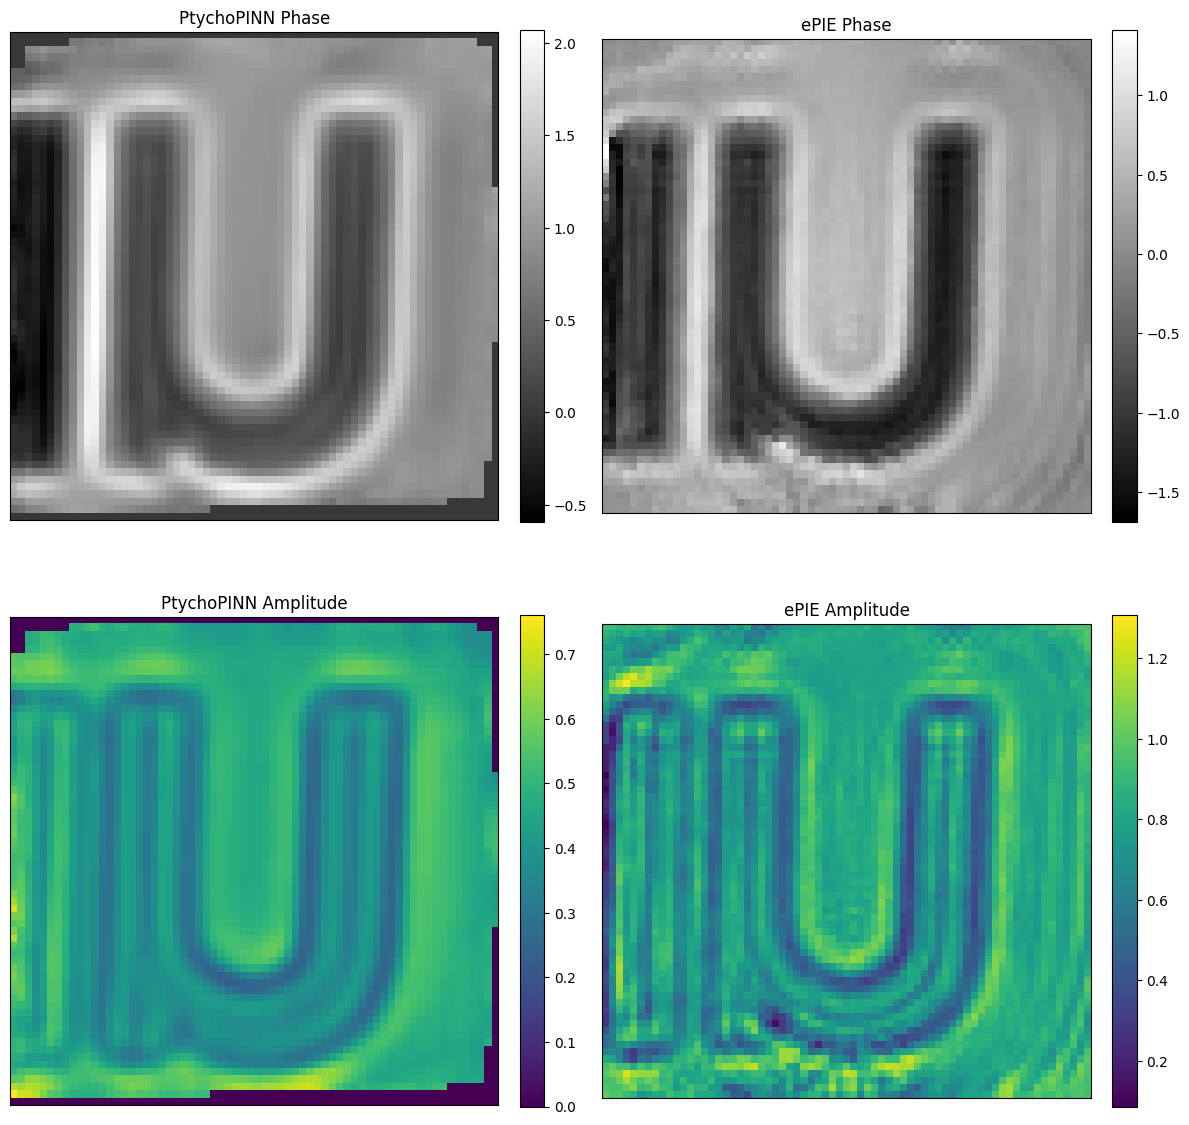

In [8]:
def save_comparison_image(reconstructed_amplitude, reconstructed_phase, epie_amplitude, epie_phase, output_path=None):
    """
    Create and display the comparison figure with reconstructed and ePIE results.
    If output_path is provided, save the figure to that path.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # PtychoPINN phase
    im_pinn_phase = axs[0, 0].imshow(reconstructed_phase, cmap='gray')
    axs[0, 0].set_title('PtychoPINN Phase')
    fig.colorbar(im_pinn_phase, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    # ePIE phase
    im_epie_phase = axs[0, 1].imshow(epie_phase, cmap='gray')
    axs[0, 1].set_title('ePIE Phase')
    fig.colorbar(im_epie_phase, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # PtychoPINN amplitude
    im_pinn_amp = axs[1, 0].imshow(reconstructed_amplitude, cmap='viridis')
    axs[1, 0].set_title('PtychoPINN Amplitude')
    fig.colorbar(im_pinn_amp, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    # ePIE amplitude
    im_epie_amp = axs[1, 1].imshow(epie_amplitude, cmap='viridis')
    axs[1, 1].set_title('ePIE Amplitude')
    fig.colorbar(im_epie_amp, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    # Remove axis ticks
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
from ptycho.nbutils import reconstruct_image, crop_to_non_uniform_region_with_buffer, mk_epie_comparison2x2, probeshow
import numpy as np
import matplotlib.pyplot as plt

epie_amplitude = crop_to_non_uniform_region_with_buffer(np.abs(test_data.objectGuess), buffer=-20)
epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(test_data.objectGuess), buffer=-20)

# Create and display the comparison image
save_comparison_image(recon_amp, recon_phase, epie_amplitude, epie_phase)

In [8]:
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data

NameError: name 'ptycho_dataset' is not defined

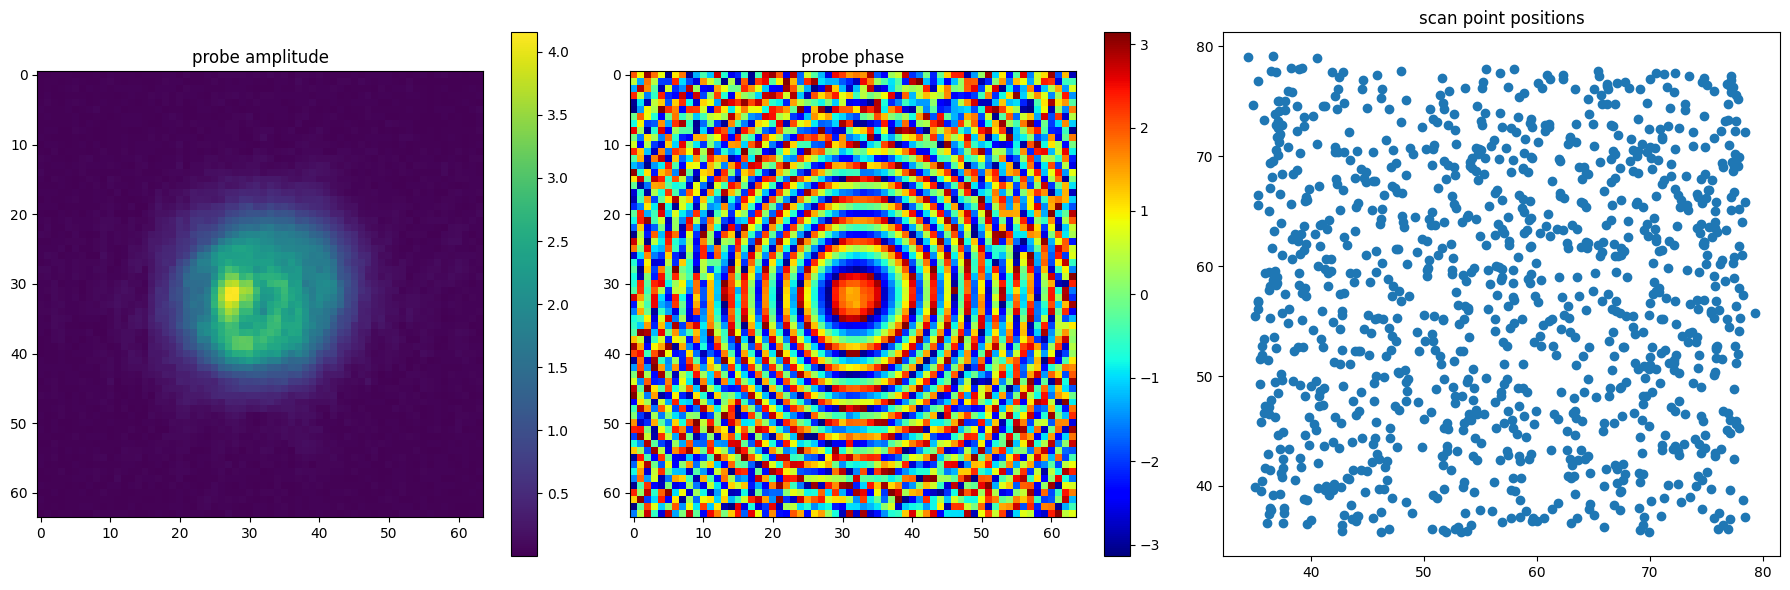

In [26]:
# Note the randomized scan point positions
probeshow(probeGuess, test_data)

In [14]:
loaded_mod = ModelManager.load_model('tmp/08-13-2024-16.00.27_//wts.h5')

DEBUG: Setting intensity_scale to 1474.2617 in params
input shape (1, 64, 64, 1)


Reconstruction for a single solution region:

In [27]:
# i = 200
# from ptycho import evaluation
# evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
#                      np.absolute(p.get('probe')[:, :, 0, 0]), 0,
#                     crop = False);

NameError: name 'pred_amp' is not defined